In [5]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [111]:
# Input image

foreground = cv2.imread("iphone_15.jpeg")
background = cv2.imread('3625454299.png')

In [75]:
def resize_foreground(foreground, background):
    bg_height, bg_width = background.shape[:2]
    fg_height, fg_width = foreground.shape[:2]

    if fg_height < bg_height and fg_width < bg_width:
        return foreground

    # Calculate scaling factors for width and height
    scale_width = bg_width / fg_width
    scale_height = bg_height / fg_height

    # Choose the minimum scaling factor to maintain aspect ratio
    scale_factor = min(scale_width, scale_height)

    # Resize the foreground image
    resized_foreground = cv2.resize(foreground, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # If the foreground has an alpha channel, resize it accordingly
    if len(resized_foreground.shape) == 3 and resized_foreground.shape[2] == 4:
        alpha = resized_foreground[:, :, 3]
        alpha = cv2.resize(alpha, (resized_foreground.shape[1], resized_foreground.shape[0]), interpolation=cv2.INTER_AREA)
        resized_foreground = resized_foreground[:, :, :3]

        # Merge resized foreground with resized alpha channel
        resized_foreground = cv2.merge((resized_foreground, alpha))
    return resized_foreground

In [81]:
def show_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

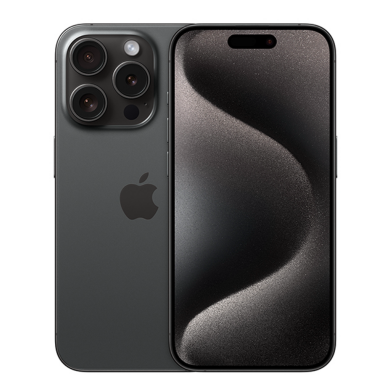

(600, 600, 3)

In [76]:
f = resize_foreground(cv2.imread("iphone_15.jpeg"), cv2.imread('3625454299.png'))
plt.axis('off')
plt.imshow(f)
plt.show()
f.shape

In [131]:
gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# figure out to not crop the background, but resize the foreground (product image) to fit into the background
# if the width and height of the foreground is smaller than the background, should we crop?
crop_background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]), interpolation = cv2.INTER_NEAREST)
_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
mask = mask.astype(np.float64) / 255

result = (foreground * mask + crop_background * (1 - mask))
result = result.clip(0, 255).astype(np.uint8)

# crop_background.shape
result.shape

(600, 600, 3)

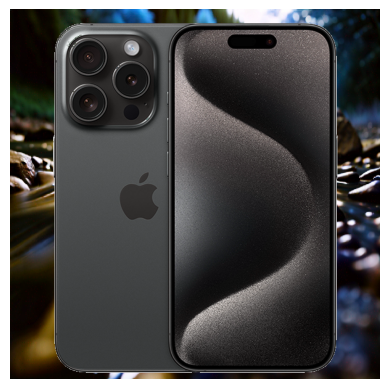

In [132]:
show_img(result)

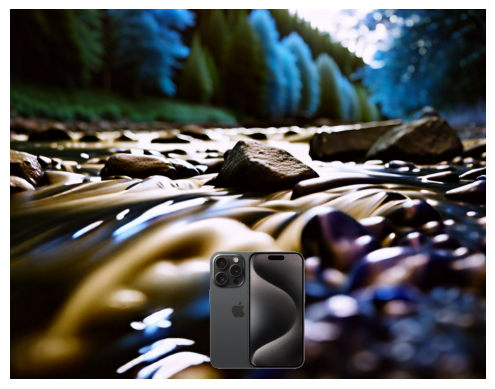

In [148]:
# https://datahacker.rs/012-blending-and-pasting-images-using-opencv/
# remove white bg

# get roi: region of interest, to which you want to put your image into
# ideally, foreground shape < background shape. If so, then resize foreground to be smaller

res = np.copy(background)

smaller_foreground = cv2.resize(foreground, (300, 300))

x_offset = res.shape[0] // 2
y_offset = res.shape[1] // 2

x_end = smaller_foreground.shape[0] + x_offset
y_end = smaller_foreground.shape[1] + y_offset

roi = res[y_offset:y_end,x_offset:x_end]

gray = cv2.cvtColor(smaller_foreground, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
mask = mask.astype(np.float64) / 255


result = (smaller_foreground * mask + roi * (1 - mask))
result = result.clip(0, 255).astype(np.uint8)

res[y_offset:y_end,x_offset:x_end] = result
show_img(res)




In [149]:
def put_into_bg(bg, fg, x, y):
    res = np.copy(bg)
    smaller_foreground = cv2.resize(fg, (x, y))

    x_offset = res.shape[0] // 2
    y_offset = res.shape[1] // 2

    x_end = smaller_foreground.shape[0] + x_offset
    y_end = smaller_foreground.shape[1] + y_offset

    roi = res[y_offset:y_end,x_offset:x_end]

    gray = cv2.cvtColor(smaller_foreground, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask = mask.astype(np.float64) / 255


    result = (smaller_foreground * mask + roi * (1 - mask))
    result = result.clip(0, 255).astype(np.uint8)

    res[y_offset:y_end,x_offset:x_end] = result

    return res